# Time Series Forecasting with NeuralForecast 

In this tutorial, we will explain how to forecast time series data using Nixtla's [`NeuralForecast`](https://nixtlaverse.nixtla.io/neuralforecast/index.html). `NeuralForecast` is a Python library that offers a large collection of neural forecasting models, focusing on their performance, usability, and robustness.

We will use the [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) dataset, which contains hierarchical sales data from Walmart spanning five years. The goal of this tutorial is to forecast sales for the next 28 days.

First, we will generate several models from `NeuralForecast` and use time series cross-validation on the training set to select the best model for each series. Then, we will generate a 28-day-ahead forecast, mirroring the approach used in the competition. Finally, we will compare our forecast with the competition's test set to evaluate overall performance.

**Outline:**
1. Load and Visualize the Data

2. Perform Time Series Cross-Validation

3. Select the Best Model for Each Series

4. Fit and Predict

5. Evaluate the Results

6. **Bonus Section**: M5 Competition Model Evaluation 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

To suppress the progress bar, set `ENABLE_PROGRESS_BAR` to `False` in the environment variables. You can do this in your terminal by using the following command:

```bash
export ENABLE_PROGRESS_BAR=False
```

## 1. Load and Visualize the Data 

We can download the M5 Competition dataset from a parquet file using `pandas`.

In [3]:
import pandas as pd 

Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')
Y_df.head()

,item_id,timestamp,demand
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0


We need to adjust the columns to conform to `NeuralForecast`'s requirements. The input to `NeuralForecast` should be a DataFrame in long format with three columns: 

- `unique_id` (string, int or category): A unique identifier for each series. 

- `ds` (int or timestamp): An integer indexing time or a timestamp in format 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'.

- `y` (numeric): The target variable to forecast, in this case, daily sales. 

In [4]:
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

Y_df['unique_id'] = Y_df['unique_id'].astype(str)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

The complete M5 Competition dataset contains 30,490 series, with each series representing the daily sales of a specific item. These items are organized in a hierarchical structure across multiple levels: department, category, store, and state.

You can leverage the capabilities of **LightningAI** to generate a forecast for all the series in the dataset or you can select a sample of series. To select all the series that correspond to a specific department, for example, you can simply filter the dataset and then continue with the tutorial.

```python
Y_df = Y_df[Y_df['unique_id'].str.contains("FOODS_3_001")].reset_index(drop=True)
``````

We will use the `plot_series` function from [utilsforecast](https://nixtlaverse.nixtla.io/utilsforecast/index.html) to visualize the data. `utilsforecast` is Python library from Nixtla designed to support various forecasting tasks. 

In [5]:
from utilsforecast.plotting import plot_series 

plot_series(Y_df, engine='plotly')

The `plot_series` function takes the following arguments: 

- `df` (DataFrame): The input data with columns `unique_id`, `ds`, and `y`.

- `max_insample_length` (int): The maximum number of observations to plot. 

- `engine` (str): The plotting engine to use: '`plotly`' or '`matplotlib`'. 

## 2. Perform Time Series Cross-Validation

In this section, we will generate several models using `NeuralForecast` and then select the best model for each series using time series cross-validation.

Time series cross-validation is a method for evaluating how a model would have performed on historical data. It works by defining a sliding window across past observations and then predicting the period following it. This method differs from standard cross-validation by maintaining the chronological order of the data instead of randomly splitting it. 

Before running the cross-validation, we need to import the models from `NeuralForecast` that we will use. Keep in mind that their performance is greatly affected by the choice of hyperparameters. `NeuralForecast` has automatized and simplified the hyperparameter tuning process with the `Auto` models. Each model in the library has an `Auto` version that performs hyperparameter selection on either a default or custom search space.

The `Auto` models can be used with two backends: Ray's [Tune](https://docs.ray.io/en/master/tune/index.html) and [Optuna](https://optuna.org/). In this tutorial, we will use the `AutoNHITS`, `AutoTFT`, and `AutoDeepAR` models with Ray's Tune backend and a custom search space. 

### Model selection 

The selection of models was done with diversity in mind, considering different deep learning architectures:

- [`AutoNHITS`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autonhits): This model is an MLP-based deep neural architecture featuring backward and forward residual links. It addresses volatility and memory complexity by locally specializing its predictions to adapt to different signal frequencies, using hierarchical interpolation and pooling techniques.

- [`AutoTFT`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autotft): This transformer-based sequence-to-sequence model uses static, historical, and future data to predict a univariate target. It integrates gating layers, an LSTM recurrent encoder, and an interpretable multi-head attention layer to enhance prediction accuracy, employing a multi-step forecasting strategy in its decoder.

- [`AutoDeepAR`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autodeepar): This model produces produces probabilistic forecasts based on an autoregressive recurrent neural network (RNN) optimized on panel data using cross-learning. 

In [6]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT, AutoDeepAR
from neuralforecast.losses.pytorch import DistributionLoss

To instantiate an `Auto` model we need to define the following parameters: 

- `h` (int): The forecast horizon.

- `loss`: Training and validation loss from `neuralforecast.losses.pytorch`.

- `config` (dict): A dictionary with the hyperparameter search space. 

- `search_alg`: The search algorithm to use. Default is random search. 

- `num_samples` (int): Number of configurations explored. 

In this tutorial, we will set `h=28`, mirroring the M5 Competition, and will use a `Poisson` loss with a custom search space as defined below. We will use the default search algorithm and explore two configurations, so we will set `num_samples=2`.

In [7]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),          # Lenght of input window 
    "n_blocks": 5*[1],                                          # Number of blocks for each stack                                           
    "mlp_units": 5 * [[512, 512]],                              # Structure of hidden layers for each stack type    
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],        
                                      [8, 4, 2, 1, 1]]),        # MaxPooling Kernel size     
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],          
                                      [1, 1, 1, 1, 1]]),        # Interpolation expressivity ratios    
    "learning_rate": tune.loguniform(1e-4, 1e-2),               # Initial learning rate
    "scaler_type": tune.choice([None]),                         # Scaler type
    "max_steps": tune.choice([1000]),                           # Max number of training iterations  
    "batch_size": tune.choice([32, 64, 128, 256]),              # Number of series in batch     
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),   # Number of windows in batch     
    "random_seed": tune.randint(1, 20),                            
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                # Lenght of input window    
        "hidden_size": tune.choice([64, 128, 256]),                 # Size of embeddings and encoders     
        "learning_rate": tune.loguniform(1e-4, 1e-2),               # Initial learning rate    
        "scaler_type": tune.choice([None]),                         # Scaler type   
        "max_steps": tune.choice([500, 1000]),                      # Max number of training iterations    
        "batch_size": tune.choice([32, 64, 128, 256]),              # Number of series in batch    
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),   # Number of windows in batch
        "random_seed": tune.randint(1, 20),                         
    }

config_deepar = {
    "input_size": tune.choice([28, 28*2, 28*3]),                # Lenght of input window               
    "learning_rate": tune.loguniform(1e-4, 1e-2),               # Initial learning rate
    "scaler_type": tune.choice([None]),                         # Scaler type
    "max_steps": tune.choice([500, 1000]),                      # Max number of training iterations    
    "batch_size": tune.choice([32, 64, 128, 256]),              # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),   # Number of windows in batch
    "random_seed": tune.randint(1, 20),
    }

Now that we have defined the search space for each model, we can instantiate the `NeuralForecast` class. 

In [8]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2), 
        AutoDeepAR(h=28, config=config_deepar, loss=DistributionLoss(distribution='Poisson', return_params=False), num_samples=2)
    ],
    freq='D'
)

The `cross_validation` method takes the following arguments: 

- `df` (DataFrame): The input data in the format described in the previous section. 

- `n_windows` (int): The number of windows to evaluate. Default is 1 and we will use 3. 

- `step_size` (int): The number of steps between consecutive windows to produce the forecasts. In this tutorial, we will set `step_size=28`, which is the forecast horizon. 

In [ ]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

The output of the `cross_validation` method is a DataFrame with the following columns:

- `unique_id`: The unique identifier for each series.

- `ds`: The timestamp or temporal index. 

- `cutoff`: The last timestamp or temporal index used in that cross-validation window. 

- `model`: Columns with the model's point and median forecast. By default, the 80 and 90% prediction intervals are also included when using the `Poisson` loss.

- `y`: The actual variable 

In [17]:
cv_df = cv_df.reset_index()
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTFT,...,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90,y
0,FOODS_1_001_CA_1,2016-02-29,2016-02-28,0.557,0.5,0.000000,0.900002,0.900024,0.049988,0.536,...,1.800003,0.000000,0.049988,0.59,0.0,0.0,0.0,2.0,2.000000,1.0
1,FOODS_1_001_CA_1,2016-03-01,2016-02-28,0.610,0.0,1.000000,0.099998,0.000000,0.950012,0.553,...,0.900002,1.000000,1.900024,0.75,1.0,0.0,0.0,2.0,2.049995,0.0
2,FOODS_1_001_CA_1,2016-03-02,2016-02-28,0.730,0.5,0.099998,1.000000,0.199951,0.049988,0.552,...,0.099998,0.000000,1.900024,0.62,0.0,0.0,0.0,2.0,2.000000,1.0
3,FOODS_1_001_CA_1,2016-03-03,2016-02-28,0.654,0.5,0.049999,0.900002,2.099976,0.950012,0.574,...,1.800003,2.900024,0.049988,0.78,1.0,0.0,0.0,2.0,2.000000,0.0
4,FOODS_1_001_CA_1,2016-03-04,2016-02-28,0.644,1.0,1.000000,0.000000,0.900024,0.099976,0.552,...,0.099998,0.099976,0.099976,0.51,0.0,0.0,0.0,1.0,2.000000,0.0


The M5 Competition featured two tracks: accuracy and uncertainty. The accuracy track aimed to estimate the point forecasts of unit sales, while the uncertainty track focused on estimating the uncertainty distribution of the realized values of these sales.

In this tutorial, we will focus on aspects of both tracks, so we will consider the point forecasts and the 80 and 90% prediction intervals from the `Auto` models. 

In [18]:
cv_df.drop(columns=[col for col in cv_df.columns if '-median' in col], inplace=True)

The `plot_series` function that we introduced earlier can also be used to visualize the results of the cross-validation, including the prediction intervals via the `level` argument.

In [19]:
plot_series(Y_df, cv_df.drop(columns=['y', 'cutoff']), level=[80,90], max_insample_length=300, engine='plotly')

## 3. Select the Best Model for Each Series

To select the best model for each series, we can use either the point forecasts or the prediction intervals. In this tutorial, we will use the former along with the Root Mean Squared Error (RMSE), defined as the square root of the average squared errors. For convenience, we will use the `evaluate` and `rmse` functions from `utilsforecast`.

In [20]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import rmse 

The `evaluate` function takes the following arguments:

- `df` (DataFrame): The data frame with the forecasts to evaluate.

- `metrics` (list): The metrics to compute.

- `models` (list): Names of the models to evaluate. Default is None, which uses all columns after removing id_col, time_col, and target_col.

- `id_col` (str): Column that identifies unique ids of the series. Default is `unique_id`.

- `time_col` (str): Column with the timestamps or the temporal index. Default is `ds`.

- `target_col` (str): Column with the target variable. Default is `y`.

In [21]:
models = ['AutoNHITS', 'AutoDeepAR', 'AutoTFT']
eval_cv = cv_df.groupby('cutoff').apply(lambda cv_df: evaluate(cv_df, metrics=[rmse], models=models), include_groups=False)

For every `unique_id`, we will select the model with the lowest RMSE. 

In [22]:
eval = eval_cv.groupby(['unique_id'])[models].mean().reset_index()
eval['best_model'] = eval[models].idxmin(axis=1)
eval.head()

,unique_id,AutoNHITS,AutoDeepAR,AutoTFT,best_model
0,FOODS_1_001_CA_1,1.195151,1.199667,1.204874,AutoNHITS
1,FOODS_1_001_CA_2,1.762116,1.746054,1.752208,AutoDeepAR
2,FOODS_1_001_CA_3,2.094380,2.155419,2.154855,AutoNHITS
3,FOODS_1_001_CA_4,0.680519,0.741442,0.653904,AutoTFT
4,FOODS_1_001_TX_1,0.905199,0.861653,0.929161,AutoDeepAR


We can summarize the results to see how many times each model won. 

In [23]:
summary_df = eval.groupby(['best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['model', 'unique_ids']
summary_df

,model,unique_ids
0,AutoDeepAR,3979
1,AutoTFT,9289
2,AutoNHITS,17222


We can also visualize these results using matplotlib. 

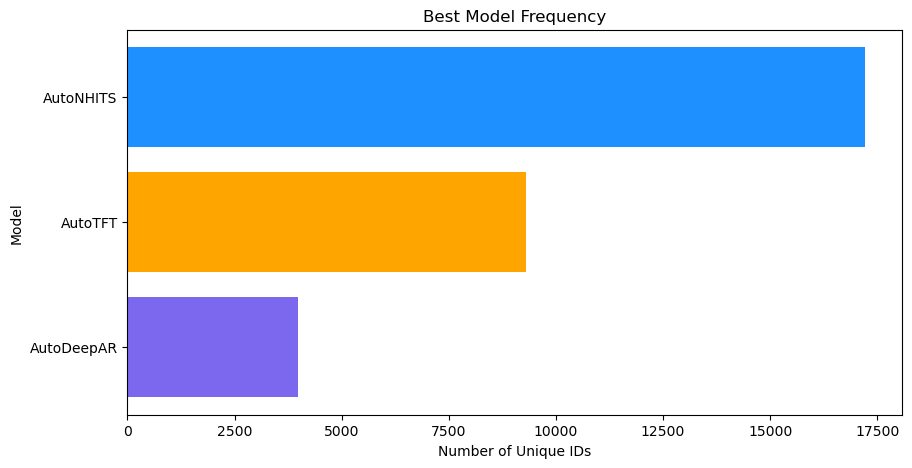

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Adjust the size as needed
plt.barh(summary_df['model'], summary_df['unique_ids'], color=['mediumslateblue', 'orange', 'dodgerblue'])  # Using a color similar to the 'viridis' palette
plt.xlabel('Number of Unique IDs')  # X-axis label
plt.ylabel('Model')  # Y-axis label
plt.title('Best Model Frequency')  # Title of the plot
plt.show()

With this information, we can now determine which model performed best for each series in the historical data, and we will save these results in a dictionary.

In [25]:
best_model = {
    'AutoNHITS': eval[eval['best_model'] == 'AutoNHITS']['unique_id'].values,
    'AutoDeepAR': eval[eval['best_model'] == 'AutoDeepAR']['unique_id'].values,
    'AutoTFT': eval[eval['best_model'] == 'AutoTFT']['unique_id'].values
}

## 4. Fit and Predict 

In this section, we will train the `Auto` models on the entire dataset using the `fit` method. Following this, we will employ the `predict` method to forecast sales for the next 28 days.

In [ ]:
nf.fit(Y_df)

In [ ]:
fcst_df = nf.predict()

In [29]:
fcst_df = fcst_df.reset_index()
fcst_df.head()

,unique_id,ds,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTFT,AutoTFT-median,AutoTFT-lo-90,AutoTFT-lo-80,AutoTFT-hi-80,AutoTFT-hi-90,AutoDeepAR,AutoDeepAR-median,AutoDeepAR-lo-90,AutoDeepAR-lo-80,AutoDeepAR-hi-80,AutoDeepAR-hi-90
0,FOODS_1_001_CA_1,2016-05-23,0.839,1.0,0.0,0.0,2.0,3.0,1.009,1.0,0.0,0.0,2.0,3.0,0.78,1.0,0.0,0.0,2.0,2.0
1,FOODS_1_001_CA_1,2016-05-24,0.895,1.0,0.0,0.0,2.0,3.0,1.019,1.0,0.0,0.0,2.0,3.0,0.70,1.0,0.0,0.0,2.0,2.0
2,FOODS_1_001_CA_1,2016-05-25,0.758,1.0,0.0,0.0,2.0,2.0,1.028,1.0,0.0,0.0,2.0,3.0,0.79,1.0,0.0,0.0,2.0,2.0
3,FOODS_1_001_CA_1,2016-05-26,0.683,1.0,0.0,0.0,2.0,2.0,0.925,1.0,0.0,0.0,2.0,3.0,0.63,0.0,0.0,0.0,2.0,2.0
4,FOODS_1_001_CA_1,2016-05-27,0.827,1.0,0.0,0.0,2.0,2.0,0.914,1.0,0.0,0.0,2.0,3.0,0.68,0.0,0.0,0.0,2.0,2.0


As before, we will select the point forecasts and the 80 and 90% prediction intervals.

In [30]:
fcst_df.drop(columns=[col for col in cv_df.columns if '-median' in col], inplace=True)

Now for each series, we will select the best model according to the results of the time series cross-validation. 

In [31]:
best_model_dfs = []  # A list to hold the best model for each unique_id

for model in models:
    model_df = fcst_df[fcst_df['unique_id'].isin(best_model[model])]
    rename_dict = {
        model: 'best-model',
        model+'-lo-80': 'best-model-lo-80',
        model+'-hi-80': 'best-model-hi-80',
        model+'-lo-90': 'best-model-lo-90',
        model+'-hi-90': 'best-model-hi-90'
    }
    model_df = model_df.rename(columns=rename_dict)
    model_df = model_df[['unique_id', 'ds'] + list(rename_dict.values())]
    best_model_dfs.append(model_df)

forecast = pd.concat(best_model_dfs, axis=0)
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast.head()


,unique_id,ds,best-model,best-model-lo-80,best-model-hi-80,best-model-lo-90,best-model-hi-90
0,FOODS_1_001_CA_1,2016-05-23,0.839,0.0,2.0,0.0,3.0
1,FOODS_1_001_CA_1,2016-05-24,0.895,0.0,2.0,0.0,3.0
2,FOODS_1_001_CA_1,2016-05-25,0.758,0.0,2.0,0.0,2.0
3,FOODS_1_001_CA_1,2016-05-26,0.683,0.0,2.0,0.0,2.0
4,FOODS_1_001_CA_1,2016-05-27,0.827,0.0,2.0,0.0,2.0


We can plot model we selected for each series using the `plot_series` function. 

In [32]:
plot_series(Y_df, forecast, level = [80,90], max_insample_length=300, engine='plotly')

## 5. Evaluate the Results 

Finally, we will evaluate the 28-day-ahead forecasts we generated using the actual values from the M5 Competition. The point forecasts will be assessed using various accuracy metrics, while the prediction intervals will be evaluated with a scaled version of the Continuous Ranked Probability Score (CRPS).

First, we will load the test set that contains the actual values and merge it with our forecasts.

In [33]:
test_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/test/target.parquet') 

test_df = test_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

test_df['unique_id'] = test_df['unique_id'].astype(str)
test_df['ds'] = pd.to_datetime(test_df['ds'])

res_df = test_df.merge(forecast, on=['unique_id', 'ds'], how='left')

Now, we need to import the additional accuracy metrics  that we will use. Note that `mase` requires the `partial` function from `functools` and the historical data. 

We can compute all the accuracy metrics using the `evaluate` function that we used earlier. 

In [34]:
from utilsforecast.losses import mae, mase, smape, scaled_crps 
from functools import partial

In [35]:
metrics = [
    rmse, 
    mae, 
    partial(mase, seasonality=7), 
    smape, 
    partial(scaled_crps, quantiles=[0.8, 0.9])
]

eval_test = evaluate(
    res_df,
    metrics=metrics, 
    models=['best-model'],
    train_df=Y_df
)

In [36]:
eval_test.groupby('metric').mean(numeric_only=True).reset_index()

,metric,best-model
0,mae,1.136845
1,mase,1.163828
2,rmse,1.444285
3,scaled_crps,18.117147
4,smape,0.692464


## 6. **Bonus Section**: M5 Competition Model Evaluation

In this section, we will show that we can achieve competitive results leveraging the capabilities of `NeuralForecast` and **LightningAI**. 
Our goal is to replicate the evaluation process used in the accuracy track of the M5 Competition, which used the Weighted Root Mean Scaled Squared Error (WRMSSE) as the evaluation metric. This evaluation is applicable only if you have generated a forecast for the complete dataset. 

To compute the WRMSSE, we need static variables for each `unique_id`. These static variables include contextual information about each unique series in the dataset and they can be downloaded from `datasetsforecast`, a Nixtla library that offers several publicly available datasets for time series forecasting. This library also contains a function to compute the WRMSSE.

In [37]:
from datasetsforecast.m5 import M5, M5Evaluation

To download and load the data from the M5 Competition, we need to select a directory. For convenience, we will use the current working directory. 

In [38]:
import os 

directory = os.getcwd()
M5.download(directory)
_, _, S_df = M5.load(directory) # load only static variables 
S_df.head()

,unique_id,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX


To compute the WRMSSE, we need to transform the forecast from long to wide format, rename the columns, and merge the static variables. 

In [39]:
y_hat = forecast.pivot(index='unique_id', columns='ds', values='best-model')
y_hat.columns = ['d_' + str(i + 1) for i in range(len(y_hat.columns))]
res = y_hat.merge(S_df, on='unique_id', how='left')
res.head()


,unique_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_24,d_25,d_26,d_27,d_28,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,0.839,0.895,0.758,0.683,0.827,0.824,0.931,0.989,0.917,...,0.837,0.797,0.848,0.898,0.967,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,0.620,0.570,0.600,0.600,0.720,0.700,0.530,0.700,0.630,...,0.650,0.600,0.670,0.580,0.680,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,1.056,0.851,0.829,0.876,1.084,1.198,1.262,1.065,0.890,...,0.862,0.789,0.979,1.108,1.171,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_001_CA_4,0.512,0.474,0.415,0.401,0.414,0.375,0.389,0.409,0.464,...,0.499,0.490,0.485,0.466,0.496,FOODS_1_001,FOODS_1,FOODS,CA_4,CA
4,FOODS_1_001_TX_1,0.990,1.090,1.130,1.320,1.170,0.990,1.200,1.080,1.140,...,1.140,1.090,1.020,1.070,1.050,FOODS_1_001,FOODS_1,FOODS,TX_1,TX


To use the `evaluate` function from the `M5Evaluation` class, we need to provide the directoy where the data was downloaded and the forecasts in the previous format. 

In [40]:
results = M5Evaluation.evaluate(directory=directory, y_hat=res)
results 

,wrmsse
Total,0.846097
Level1,0.672951
Level2,0.711318
Level3,0.746686
Level4,0.758965
Level5,0.887049
Level6,0.807268
Level7,0.905766
Level8,0.821931
Level9,0.909346


At the lowest level of the hierarchy, where we generated the forecasts, we achieved a WRMSSE of 0.911. This score places the forecast within the [top 50 entries](https://www.sciencedirect.com/science/article/pii/S0169207021001874) at this level, showcasing the success of leveraging `NeuralForecast` and **LightningAI** for time series forecasting.